In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from typing import Union, List, Optional
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from torchhd.embeddings import Projection
from torchhd.models import Centroid
import ipywidgets as widgets
from IPython.display import display, clear_output

In [40]:
class PTBXL_Dataset(Dataset):
    """
    A PyTorch Dataset for ECG samples grouped by subject (PTB-XL).

    Args:
        data_path (str): Path to the .pt file with data grouped by subject.
        subject_ids (Union[float, List[float], None]): Subject(s) to include. If None, uses all subjects.
        split (str): 'train', 'test', or None — whether to return a subset.
        test_ratio (float): Proportion to reserve for test split (if split is specified).
        random_seed (int): Random seed for reproducibility.
    """
    def __init__(
        self,
        data_path: str,
        subject_ids: Optional[Union[float, List[float]]] = None,
        split: Optional[str] = None,
        test_ratio: float = 0.2,
        val_ratio: float = 0.2,
        random_seed: int = 42
    ):
        assert split in [None, 'train', 'val', 'test'], "split must be None, 'train', 'val', or 'test'"

        raw_data = torch.load(data_path)
        all_subject_data = raw_data['data_by_subject']
        self.label_encoder = raw_data['label_encoder']
        # label index: [0:'AFIB' 1:'NORM' 2:'PAC' 3:'PVC' 4:'SBRAD' 5:'STACH']

        # Normalize subject_ids to list
        if subject_ids is None:
            selected_subjects = list(all_subject_data.keys())
        elif isinstance(subject_ids, float):
            selected_subjects = [subject_ids]
        else:
            selected_subjects = subject_ids

        # Collect all (x, y) pairs per subject
        all_samples = []

        for sid in selected_subjects:
            subject_data = all_subject_data[sid]
            x_list = subject_data['x']
            y_list = subject_data['y']
            samples = list(zip(x_list, y_list))
            all_samples.extend(samples)

        # Split based on sample count
        if split is not None:
            stratify_labels = [int(y) for _, y in all_samples]

            # First split into temp (train+val) and test
            temp_idx, test_idx = train_test_split(
                range(len(all_samples)),
                test_size=test_ratio,
                random_state=random_seed,
                stratify=stratify_labels
            )

            temp_samples = [all_samples[i] for i in temp_idx]
            temp_labels = [int(y) for _, y in temp_samples]

            # Now split temp into train and val
            train_idx, val_idx = train_test_split(
                range(len(temp_samples)),
                test_size=val_ratio,
                random_state=random_seed,
                stratify=temp_labels
            )

            if split == 'train':
                indices = [temp_idx[i] for i in train_idx]
            elif split == 'val':
                indices = [temp_idx[i] for i in val_idx]
            elif split == 'test':
                indices = test_idx

            self.samples = [all_samples[i] for i in indices]
        else:
            self.samples = all_samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return x.unsqueeze(0), y  # Add channel dimension: (1, 2500)

In [41]:
class MITBIH_Dataset(Dataset):
    """
    A PyTorch Dataset for ECG samples grouped by subject (MIT-BIH).

    Args:
        data_path (str): Path to the .pt file with data grouped by subject.
        normal (bool or None): If True, include only normal (label == 0); if False, only abnormal; if None, include all.
        subject_ids (Union[float, List[float], None]): Subject(s) to include. If None, uses all subjects.
        split (str): 'train', 'test', or None — whether to return a subset.
        test_ratio (float): Proportion to reserve for test split.
        random_seed (int): Random seed for reproducibility.
    """
    def __init__(
        self,
        data_path: str,
        normal: Optional[bool] = None,
        subject_ids: Optional[Union[float, List[float]]] = None,
        split: Optional[str] = None,
        test_ratio: float = 0.6,
        random_seed: int = 42
    ):
        assert split in [None, 'train', 'test'], "split must be None, 'train', or 'test'"

        raw_data = torch.load(data_path)
        all_subject_data = raw_data['data_by_subject']
        self.label_encoder = raw_data['label_encoder']

        # Normalize subject_ids
        if subject_ids is None:
            selected_subjects = list(all_subject_data.keys())
        elif isinstance(subject_ids, float):
            selected_subjects = [subject_ids]
        else:
            selected_subjects = subject_ids

        # Collect and filter samples
        all_samples = []
        for sid in selected_subjects:
            subject_data = all_subject_data[sid]
            for x, y in zip(subject_data['x'], subject_data['y']):
                y_int = int(y.item())
                if normal is True and y_int != 0:
                    continue  # keep only label==0
                if normal is False and y_int == 0:
                    continue  # exclude label==0
                if normal is False:
                    y_int -= 1  # shift all labels by -1 so they start from 0

                all_samples.append((x, torch.tensor(y_int)))

        if len(all_samples) == 0:
            raise ValueError("No samples in the dataset. Check filtering conditions.")

        # Optional split
        if split is not None:
            stratify_labels = [int(y) for _, y in all_samples]
            if len(set(stratify_labels)) > 1 and min([stratify_labels.count(cls) for cls in set(stratify_labels)]) >= 2:
                train_idx, test_idx = train_test_split(
                    range(len(all_samples)),
                    test_size=test_ratio,
                    random_state=random_seed,
                    stratify=stratify_labels
                )
            else:
                train_idx, test_idx = train_test_split(
                    range(len(all_samples)),
                    test_size=test_ratio,
                    random_state=random_seed,
                    stratify=None
                )
            indices = train_idx if split == 'train' else test_idx
            self.samples = [all_samples[i] for i in indices]
        else:
            self.samples = all_samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return x.unsqueeze(0), y  # Add channel dimension (1, 2500)

In [42]:
class ECGNet(nn.Module):
    def __init__(self):
        super(ECGNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv1d(1, 8, 16, stride=2, padding=7),
            nn.ReLU(),
            # nn.BatchNorm1d(8),
            nn.MaxPool1d(kernel_size=8, stride=4),

            nn.Conv1d(8, 12, 12, padding=5, stride=2),
            nn.ReLU(),
            # nn.BatchNorm1d(16),
            nn.MaxPool1d(4, stride=2),

            nn.Conv1d(12, 32, 9, stride=1, padding=4),
            nn.ReLU(),
            nn.MaxPool1d(5, stride=2),

            nn.Conv1d(32, 64, 7, stride=1, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(4, stride=2),

            nn.Conv1d(64, 64, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),

            nn.Conv1d(64, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),

            nn.Conv1d(64, 72, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),
        )
        self.classifier = torch.nn.Sequential(
            nn.Linear(in_features=144, out_features=64),
            nn.ReLU(),
            nn.Dropout(p=.1),
            nn.Linear(in_features=64, out_features=6),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view((x.size(0), -1))
        x = self.classifier(x)
        return x

In [43]:
class Embedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv1d(1, 8, 16, stride=2, padding=7),
            nn.ReLU(),
            # nn.BatchNorm1d(8),
            nn.MaxPool1d(kernel_size=8, stride=4),

            nn.Conv1d(8, 12, 12, padding=5, stride=2),
            nn.ReLU(),
            # nn.BatchNorm1d(16),
            nn.MaxPool1d(4, stride=2),

            nn.Conv1d(12, 32, 9, stride=1, padding=4),
            nn.ReLU(),
            nn.MaxPool1d(5, stride=2),

            nn.Conv1d(32, 64, 7, stride=1, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(4, stride=2),

            nn.Conv1d(64, 64, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),

            nn.Conv1d(64, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),

            nn.Conv1d(64, 72, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),
        )
        self.output = nn.Linear(in_features=144, out_features=64)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.output(x)

class SiameseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = Embedding()
        self.classifier = nn.Sequential(
            nn.Linear(64 * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x1, x2):
        f1 = self.embedding(x1)
        f2 = self.embedding(x2)
        distance = torch.nn.functional.pairwise_distance(f1, f2)
        combined = torch.cat([f1, f2], dim=1)
        prob = self.classifier(combined).squeeze()
        return distance, prob

In [51]:
class HDNet(nn.Module):
    def __init__(self, normal_database, abnormal_database, normal_extractor_path, abnormal_extractor_path,
                  HD_DIM=10000, FEATURE_DIM=144, NUM_CLASSES=6):
        super().__init__()
        
        self.normal_database = normal_database
        self.abnormal_database = abnormal_database
        self.NUM_CLASSES = NUM_CLASSES
        self.HD_DIM = HD_DIM
        self.FEATURE_DIM = FEATURE_DIM
        self.labels = list(normal_database.label_encoder.classes_) + list(abnormal_database.label_encoder.classes_)

        normal_model = SiameseNet()
        normal_model.load_state_dict(torch.load(normal_extractor_path))
        self.normal_extractor = normal_model.embedding.features

        abnormal_model = ECGNet()
        abnormal_model.load_state_dict(torch.load(abnormal_extractor_path))
        self.abnormal_extractor = abnormal_model.features

        self.normal_projection = Projection(in_features=FEATURE_DIM, out_features=HD_DIM)
        self.abnormal_projection = Projection(in_features=FEATURE_DIM, out_features=HD_DIM)

        self.normal_hv = None
        self.threshold = None
        self.abnormal_classifier = None
        self.ABNORMAL_CLASS_OFFSET = 1

        self.custom_train(self.abnormal_database, init=True)

    def extract_normal_features(self, x):
        with torch.no_grad():
            features = self.normal_extractor(x)         # → shape: (1, C, L)
            return features.view(1, -1)          # → shape: (1, 144)

    def extract_abnormal_features(self, x):
        with torch.no_grad():
            features = self.abnormal_extractor(x)         # → shape: (1, C, L)
            return features.view(1, -1)          # → shape: (1, 144)
        
    def custom_train(self, patient_training_data, threshold=0.95, init=False):
        all_hvs=[]

        if init == False:
            patient_hvs = []   
            for idx in range(patient_training_data.__len__()):
                x, y = patient_training_data.__getitem__(idx)
                x = x.unsqueeze(0)  # (1, 1, 2500)
                if y.item() == 0:
                    feat = self.extract_normal_features(x)     # → shape: (1, feature_dim)
                    hv = self.normal_projection(feat)                 # → shape: (1, hd_dim)
                    hv = torch.nn.functional.normalize(hv, dim=1)  # normalize to unit vector
                    patient_hvs.append(hv.squeeze(0))         # shape: (hd_dim,)
            if len(patient_hvs) > 0:
                patient_hv = torch.stack(patient_hvs).mean(dim=0)
                all_hvs.append(patient_hv)

        if len(all_hvs) == 0:
            base_hvs = []
            for idx in range(10):
                x, y = self.normal_database.__getitem__(idx)
                x = x.unsqueeze(0)  # (1, 1, 2500)
                if y.item() == 0:
                    feat = self.extract_normal_features(x)     # → shape: (1, feature_dim)
                    hv = self.normal_projection(feat)                 # → shape: (1, hd_dim)
                    hv = torch.nn.functional.normalize(hv, dim=1)  # normalize to unit vector
                    base_hvs.append(hv.squeeze(0))         # shape: (hd_dim,)
        
            base_hv = torch.stack(base_hvs, dim=0).mean(dim=0)  # → shape: (hd_dim,)
            all_hvs.append(base_hv)

        normal_hv = torch.stack(all_hvs).mean(dim=0)  # centroid
        self.normal_hv = torch.nn.functional.normalize(normal_hv, dim=0)  # final normalized prototype
        self.threshold = threshold

        self.abnormal_classifier = Centroid(self.HD_DIM, self.NUM_CLASSES)

        for idx in range(self.abnormal_database.__len__()):
            x, y = self.abnormal_database.__getitem__(idx)
            x = x.unsqueeze(0)  # shape: (1, 1, 2500)
            y = y.unsqueeze(0)
            feat = self.extract_abnormal_features(x)     # → shape: (1, 144)
            hv = self.abnormal_projection(feat)          # → shape: (1, 10000)
            self.abnormal_classifier.add(hv, y)       # add to HDC class prototype

        if init == False:
            for idx in range(patient_training_data.__len__()):
                x, y = patient_training_data.__getitem__(idx)
                if y.item() != 0:
                    x = x.unsqueeze(0)  # (1, 1, 2500)
                    y = y.unsqueeze(0)
                    feat = self.extract_abnormal_features(x)     # → shape: (1, 144)
                    hv = self.abnormal_projection(feat)          # → shape: (1, 10000)
                    self.abnormal_classifier.add(hv, y)       # add to HDC class prototype

        # Normalize after training
        self.abnormal_classifier.normalize()

    def test(self, patient_testing_data):
        pred_labels=[]
        normal_similarities = []

        for idx in range(patient_testing_data.__len__()):
            x, y = patient_testing_data.__getitem__(idx)
            x = x.unsqueeze(0)  # (1, 1, 2500)
            y = y.item()

            # Step 1: Extract features & encode to HD space
            feat = self.extract_normal_features(x)
            hv = self.normal_projection(feat)
            hv = torch.nn.functional.normalize(hv, dim=1)
            hv = hv.squeeze(0)  # shape: (hd_dim,)

            # Step 2: Cosine similarity to prototype
            similarity = torch.nn.functional.cosine_similarity(hv, self.normal_hv, dim=0).item()
            normal_similarities.append(similarity)

            # Step 3: Classification decision
            if similarity >= self.threshold:
                pred_labels.append(0)# 0 = normal
            else:
                feats = self.extract_abnormal_features(x)   # shape: (1, 144)
                hv = self.abnormal_projection(feats)              # shape: (1, 10000)
                out = self.abnormal_classifier(hv)             # shape: (1, num_classes)
                with torch.no_grad():
                    pred = out.argmax(dim=1).item()
                pred_labels.append(pred+self.ABNORMAL_CLASS_OFFSET)

        return pred_labels, normal_similarities
        

In [ ]:
mitbih_data = torch.load("./datasets/mitbih_all_data.pt")
sub_ids = list(mitbih_data['data_by_subject'].keys())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

abnormal_train_database = PTBXL_Dataset("./datasets/ptbxl_abnormal_data.pt", split='val')
normal_train_database = PTBXL_Dataset("./datasets/ptbxl_normal_data.pt")

Using device: cpu


In [47]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
all_true_labels = []
all_pred_labels = []
all_normal_similarities = []
for sub_idx in range(len(sub_ids)):
    SUB = sub_ids[sub_idx]
    patient_train_dataset = MITBIH_Dataset("./datasets/mitbih_all_data.pt", subject_ids=[SUB] ,split='train')
    test_dataset = MITBIH_Dataset("./datasets/mitbih_all_data.pt", subject_ids=[SUB] ,split='test')
    hdnet = HDNet(normal_train_database, abnormal_train_database, "./models/NormalClassifier.pth", "./models/ECGNet_weightedLoss.pth")
    hdnet.to(device)
    hdnet.custom_train(patient_train_dataset)
    pred_labels, normal_similarities = hdnet.test(test_dataset)
    all_normal_similarities.append(normal_similarities)
    true_labels = []
    for i in range(len(test_dataset)):
        _, y = test_dataset[i]
        true_labels.append(y.item() if torch.is_tensor(y) else y)
    all_true_labels.append(true_labels)
    all_pred_labels.append(pred_labels)

In [35]:
all_classes = hdnet.labels
all_class_indices = list(range(len(all_classes)))  # ensures every class is included

true_labels = []
pred_labels = []
for item in all_true_labels:
    true_labels = true_labels + item
for item in all_pred_labels:
    pred_labels = pred_labels + item

print(classification_report(
    true_labels,
    pred_labels,
    labels=all_class_indices,
    target_names=all_classes,
    zero_division=0
))

              precision    recall  f1-score   support

        NORM       0.88      0.83      0.85       175
        AFIB       0.96      0.96      0.96        82
         PAC       0.85      0.57      0.69        40
         PVC       0.89      0.78      0.83        80
       SBRAD       0.18      1.00      0.31         6
       STACH       0.00      0.00      0.00         0

    accuracy                           0.82       383
   macro avg       0.63      0.69      0.61       383
weighted avg       0.88      0.82      0.85       383



In [36]:
similarity_score = []
for item in all_normal_similarities:
    similarity_score = similarity_score + item
similarity_score = np.array(similarity_score)
similarity_score = similarity_score.reshape(-1, 1)

normal_label = [1 if idx==0 else 0 for idx in true_labels]
y_true_bin = label_binarize(true_labels, classes=list(range(2)))  # assume classes 0~num_classes-1

# Calculate AUC
model_auc = roc_auc_score(y_true_bin, similarity_score, average='macro', multi_class='ovr')
print(f"AUC (macro): {model_auc:.4f}")

AUC (macro): 0.9466


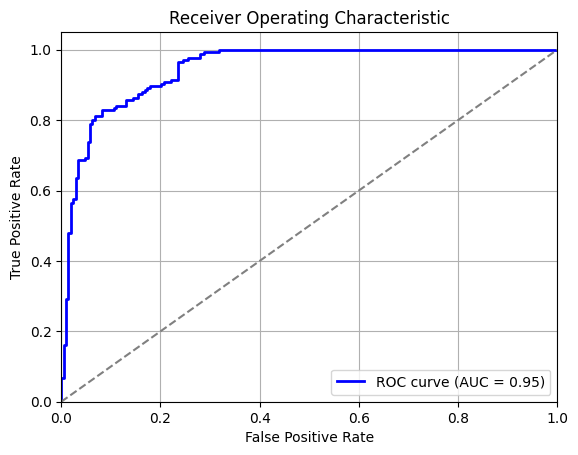

In [37]:
fpr, tpr, thresholds = roc_curve(normal_label, similarity_score)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

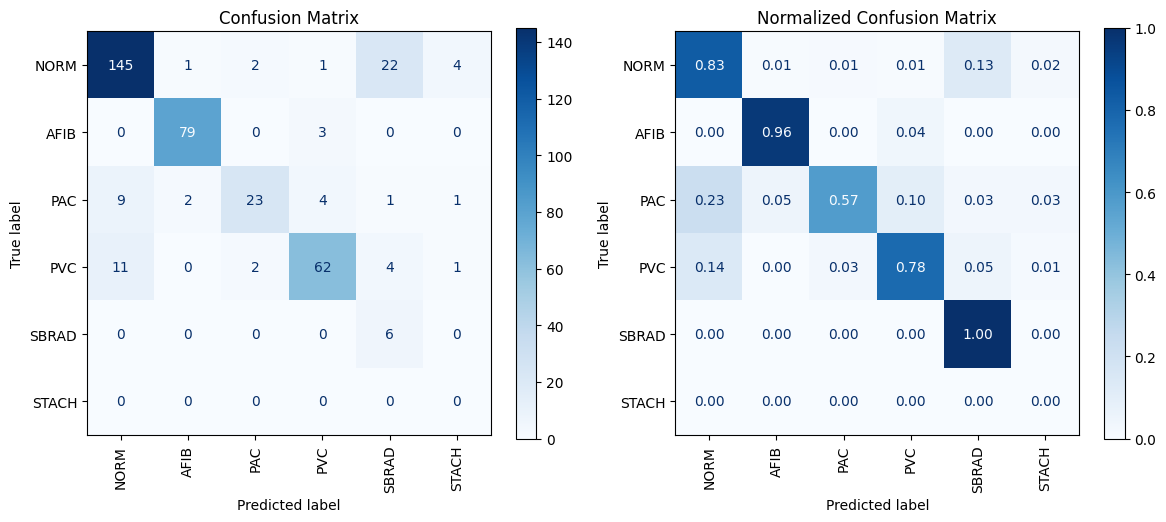

In [38]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=all_class_indices)

# Normalize
cm_normalized = np.divide(
    cm.astype('float'),
    cm.sum(axis=1)[:, np.newaxis],
    out=np.zeros_like(cm, dtype=float),
    where=cm.sum(axis=1)[:, np.newaxis] != 0
)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Raw confusion matrix
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_classes)
disp1.plot(ax=ax1, cmap='Blues', xticks_rotation='vertical', colorbar=True)
ax1.set_title("Confusion Matrix")

# Normalized confusion matrix
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=all_classes)
disp2.plot(ax=ax2, cmap='Blues', xticks_rotation='vertical', values_format=".2f", colorbar=True)
ax2.set_title("Normalized Confusion Matrix")

plt.tight_layout()
plt.show()

In [ ]:
# Dropdown selector for subjects
subject_selector = widgets.Dropdown(
    options=[(f"Subject {i}", i) for i in range(len(all_true_labels))],
    description='Subject:',
    style={'description_width': 'initial'}
)

# Output area to show results
output = widgets.Output()

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        with output:
            clear_output(wait=True)
            idx = change['new']
            print(f"Selected Subject: {idx}")
            print(classification_report(
                all_true_labels[idx],
                all_pred_labels[idx],
                labels=all_class_indices,
                target_names=all_classes,
                zero_division=0
            ))

# Bind the callback
subject_selector.observe(on_change)

# Show everything
display(subject_selector, output)

Dropdown(description='Subject:', options=(('Subject 0', 0), ('Subject 1', 1), ('Subject 2', 2), ('Subject 3', …

Output()

In [ ]:
# Dropdown selector for subjects
subject_selector = widgets.Dropdown(
    options=[(f"Subject {i}", i) for i in range(len(all_true_labels))],
    description='Subject:',
    style={'description_width': 'initial'}
)

# Output area to show results
output = widgets.Output()

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        with output:
            clear_output(wait=True)
            idx = change['new']
            print(f"Selected Subject: {idx}")
            
            # Compute confusion matrix
            cm = confusion_matrix(all_true_labels[idx], all_pred_labels[idx], labels=all_class_indices)

            # Normalize
            cm_normalized = np.divide(
                cm.astype('float'),
                cm.sum(axis=1)[:, np.newaxis],
                out=np.zeros_like(cm, dtype=float),
                where=cm.sum(axis=1)[:, np.newaxis] != 0
            )

            # Create subplots
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

            # Raw confusion matrix
            disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_classes)
            disp1.plot(ax=ax1, cmap='Blues', xticks_rotation='vertical', colorbar=True)
            ax1.set_title("Confusion Matrix")

            # Normalized confusion matrix
            disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=all_classes)
            disp2.plot(ax=ax2, cmap='Blues', xticks_rotation='vertical', values_format=".2f", colorbar=True)
            ax2.set_title("Normalized Confusion Matrix")

            plt.tight_layout()
            plt.show()

# Bind the callback
subject_selector.observe(on_change)

# Show everything
display(subject_selector, output)

Dropdown(description='Subject:', options=(('Subject 0', 0), ('Subject 1', 1), ('Subject 2', 2), ('Subject 3', …

Output()